<a href="https://colab.research.google.com/github/Vish4github/Projects/blob/master/News%20Category%20Classification%20Using%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Category Classification with Deep Learning ( Transfer learning )

## Install packages , Import libraries, Get GPU

In [0]:
!pip install fastai==0.7.0

In [0]:
!pip3 install torchvision
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [0]:
from fastai.imports import *

In [0]:
from torch import * 
!pip install Pillow==4.1.1
!pip install image
%matplotlib inline
from fastai.imports import *

In [0]:
!pip install "torchtext==0.2.3"

In [0]:
!pip3 install spacy 
!python -m spacy download en

In [0]:
!nvcc --version

In [1]:
import torch
torch.cuda.is_available()
#torch.backends.cudnn.enabled
#!nvidia-smi
#!python --version

True

In [0]:
#!pip install fastai
!pip install fastai --upgrade


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.text import Tokenizer, Vocab
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import re
import string
import pickle
import time
import sys
#!{sys.executable} -m spacy download en
import math
from pprint import pprint
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,confusion_matrix

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('movie_reviews')

#tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, stop_words="english")

# SpaCy
import spacy
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [3]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=20212a9670e16cc5b7ccd6c6e5715c3ff902a40c99d2b3d9a4c951fb1dd980fd
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [4]:
# memory footprint support libraries/code

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.5 GB  | Proc size: 580.5 MB
GPU RAM Free: 16270MB | Used: 10MB | Util   0% | Total 16280MB


# News Category Dataset - Preprocessing

In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Data/News_Category_Dataset_v2.json"
df =  pd.read_json(path,lines=True)
df.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [0]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST 

Some of the above categories can be combined under a broader umbrella - comdey and entertainment ; style and style & beauty etc

In [0]:
df.loc[(df.category =='WORLD NEWS')][['headline','short_description','category']].tail()

,headline,short_description,category
26030,The Riyadh Summits: A Workshop For A Global Fr...,Donald Trump’s presidency is currently undergo...,WORLD NEWS
26039,Donald Of Arabia,"If Trump continues on this path, the future is...",WORLD NEWS
26047,Resistance Grows Against Hungarian Government'...,Budapest is seeing its largest anti-government...,WORLD NEWS
26109,Trump’s Counter-Extremism Effort Should Addres...,The president will have to address incitement ...,WORLD NEWS
29757,What You Need To Know About North Korea's Nucl...,Experts say the country's nuclear weapons test...,WORLD NEWS


In [0]:
df.loc[(df.category =='WORLDPOST')][['headline','short_description','category']].head()

,headline,short_description,category
34622,A New American Strategy in the Middle East,,WORLDPOST
34626,Islamic Republic of Iran's Lobbyists and Spies...,,WORLDPOST
34704,Brexit And Northern Ireland: Fact vs. Fiction,"Since the Brexit referendum last summer, there...",WORLDPOST
34705,Leave No Person With Disabilities Behind,I am one of many in Bangladesh and around the ...,WORLDPOST
34719,How to Put America First--While Engaging the R...,,WORLDPOST


In [0]:
df.loc[(df.category =='LATINO VOICES')][['headline','short_description','category']].tail()

,headline,short_description,category
124413,LOOK: Latin Billboard Music Awards Fashion Hit...,,LATINO VOICES
124434,Are Deportations Rising or Falling? A Focus on...,Although clear and correct statistics are no d...,LATINO VOICES
124624,When I Chose to Stop Feeling Small: The Story ...,"No woman in my family had ever been this tall,...",LATINO VOICES
124644,More Latino Than White Students Admitted To UC,,LATINO VOICES
124667,Living and Breathing Gabriel García Márquez,Thirty years ago I lived García Márquez. Maybe...,LATINO VOICES


In [0]:
df.category = df.category.map(lambda x: "WORLD NEWS" if x == "THE WORLDPOST" else x)
df.category = df.category.map(lambda x: "ENVIRONMENT" if x == "GREEN" else x)
df.category = df.category.map(lambda x: "ARTS & CULTURE" if x == "CULTURE & ARTS" else x)
df.category = df.category.map(lambda x: "ENTERTAINMENT" if x == "COMEDY" else x)
df.category = df.category.map(lambda x: "EDUCATION" if x == "COLLEGE" else x)
df.category = df.category.map(lambda x: "FOOD & DRINK" if x == "TASTE" else x)
df.category = df.category.map(lambda x: "HEALTHY LIVING" if x == "WELLNESS" else x)
df.category = df.category.map(lambda x: "STYLE & BEAUTY" if x == "STYLE" else x)
df.category = df.category.map(lambda x: "PARENTS" if x == "PARENTING" else x)
df.category = df.category.map(lambda x: "WORLD NEWS" if x == "WORLDPOST" else x)

We have reduced the category dimensions from 41 to 31 

In [0]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 31
category
ARTS               1509
ARTS & CULTURE     2369
BLACK VOICES       4528
BUSINESS           5937
CRIME              3405
DIVORCE            3426
EDUCATION          2148
ENTERTAINMENT     21233
ENVIRONMENT        3945
FIFTY              1401
FOOD & DRINK       8322
GOOD NEWS          1398
HEALTHY LIVING    24521
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTS           12632
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE & BEAUTY    11903
TECH               2082
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WOMEN              3490
WORLD NEWS         8420
dtype: int64


Clean module

In [0]:
lemma = WordNetLemmatizer()
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
def clean_text(text):
    lower = text.lower()
    # Split into list
    wordList = lower.split()
    # Remove punctuation
    wordList_punc = ["".join(i for i in word if (i=="'")|(i not in string.punctuation)) for word in wordList]
    # Remove stopwords
    wordList_stop = [word for word in wordList_punc if word not in list(spacy_stopwords)]
    # Remove other keywords
    #wordList_key = [word for word in wordList_stop if word not in keywords]
    # Stemming
    #words_stemmed= [stemmer.stem(word) for word in wordList_key]
    # Lemmatisation
    #lemma_word = nlp(wordList)
    wordList_clean = [lemma.lemmatize(word) for word in wordList_stop]
    #wordList = [word.lemma_ for word in wordList]
    return " ".join(wordList_clean)


In [0]:
%%time
df['Clean_headline'] = df.headline.map(clean_text)
df['Clean_description'] = df.short_description.map(clean_text)

CPU times: user 56 s, sys: 126 ms, total: 56.1 s
Wall time: 56.1 s


In [0]:
df.head()

,category,headline,authors,link,short_description,date,Clean_headline,Clean_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,2 mass shooting texas week 1 tv,left husband killed child day america
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,smith join diplo nicky jam 2018 world cup's of...,course song
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,hugh grant marries time age 57,actor longtime girlfriend anna eberstein tied ...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,jim carrey blast 'castrato' adam schiff democr...,actor give dems asskicking fighting hard donal...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,julianna margulies us donald trump poop bag pi...,dietland actress said bag cathartic therapeuti...


In [0]:
# using headlines and short_description as input X

df['text'] = df.headline + " " + df.short_description
df['text_cleaned'] = df.Clean_headline + " " + df.Clean_description

In [0]:
# Split the data into train and test.
X_train, X_test, Y_train, Y_test = train_test_split(df['text_cleaned'], df['category'], test_size=0.33)

In [0]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df = 5)

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [0]:
tfidf_train.shape

(134571, 60412)

# Predicition models

In [0]:
%%time
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(tfidf_train,Y_train)
Y_predict = model.predict(tfidf_test)
accuracy = accuracy_score(Y_test,Y_predict)*100
print('The accuracy of SVM is', format(accuracy, '.2f'))

The accuracy of SVM is 67.72
CPU times: user 17.5 s, sys: 9.05 ms, total: 17.5 s
Wall time: 17.5 s


In [0]:
%%time

logistic_Regression = LogisticRegression()
logistic_Regression.fit(tfidf_train,Y_train)
Y_predict = logistic_Regression.predict(tfidf_test)
accuracy = accuracy_score(Y_test,Y_predict)*100
print('The accuracy of Logistic Regression is', format(accuracy, '.2f'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The accuracy of Logistic Regression is 66.70
CPU times: user 1min 36s, sys: 33 s, total: 2min 9s
Wall time: 1min 27s


In [0]:
%%time
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(tfidf_train, Y_train)
prediction_knn = model.predict(tfidf_test)
accuracy = accuracy_score(prediction_knn,Y_test)*100
print('The accuracy of KNeighbours Classifier is', format(accuracy, '.2f'))

The accuracy of KNeighbours Classifier is 14.41
CPU times: user 3min 4s, sys: 1.07 s, total: 3min 5s
Wall time: 3min 5s


In [0]:
%%time

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(tfidf_train, Y_train)
prediction_decision_tree = model.predict(tfidf_test)
accuracy = accuracy_score(prediction_decision_tree,Y_test)*100
print('The accuracy of Decision Tree is', format(accuracy, '.2f'))

The accuracy of Decision Tree is 48.46
CPU times: user 4min 41s, sys: 41.3 ms, total: 4min 41s
Wall time: 4min 42s


In [0]:
%%time

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=0.1)
model.fit(tfidf_train,Y_train)
Y_predict = model.predict(tfidf_test)
accuracy = accuracy_score(Y_predict,Y_test)*100
print('The accuracy of Naive Bayes is',format(accuracy, '.2f'))

The accuracy of Naive Bayes is 64.14
CPU times: user 1.85 s, sys: 5.07 ms, total: 1.86 s
Wall time: 1.86 s


# Preprocessing for Transfer Learning model

In [0]:
# tokenizing
tokenizer = Tokenizer()
#tokenizer.process_text(df.text)
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

# delete some empty and short data

df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

In [0]:
df.head()
df = df.drop(df.columns[[1,2,3,4,5,6,7,9,10,11]], axis=1)
df.shape

(199914, 2)

In [0]:
df.to_csv('/content/drive/My Drive/Data/cleaned.csv',encoding='utf-8')

In [0]:
df2 = pd.read_csv('/content/drive/My Drive/Data/cleaned.csv')
df2.head()

,Unnamed: 0,category,text
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [0]:
df2 = pd.read_csv('/content/drive/My Drive/Data/cleaned.csv')
df3 = df2
df3.head()

X=df3.sample(frac=0.85,random_state=200)
test=df3.drop(X.index)
train=X.sample(frac=0.85,random_state=200)
val=X.drop(train.index)

print(train.shape)
print(val.shape)
print(test.shape)
train.to_csv('/content/drive/My Drive/Data/train.csv',encoding='utf-8',index=False)
val.to_csv('/content/drive/My Drive/Data/val.csv',encoding='utf-8',index=False)
test.to_csv('/content/drive/My Drive/Data/test.csv',encoding='utf-8',index=False)

df3.head()

(144438, 3)
(25489, 3)
(29987, 3)


,Unnamed: 0,category,text
0,0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


### Train and validation sets

In [0]:
train_df=pd.read_csv('/content/drive/My Drive/Data/train.csv')
train_df=train_df[['category','text']]

In [0]:
valid_df=pd.read_csv('/content/drive/My Drive/Data/val.csv')
valid_df=valid_df[['category','text']]

In [0]:
#from sklearn.model_selection import train_test_split
#train_df,valid_df=train_test_split(df_text, shuffle=True, test_size=0.25)
len(train_df),len(valid_df)

(144438, 25489)

In [0]:
train_df.head(),valid_df.head()

(         category                                               text
 0    FOOD & DRINK  Luke From 'Gilmore Girls' Is Getting His Own L...
 1            TECH  The Huffington Post Is Hiring A Tech Reporter ...
 2    FOOD & DRINK  Simple Greek: Baked Sardines From Diane Kochil...
 3  HEALTHY LIVING  Political Workout Music For The Convention Glu...
 4    BLACK VOICES  AP Uses Jordan Peele Photo While Tweeting Abou...,
          category                                               text
 0        BUSINESS  ‘Nobody Speak’: How Billionaires Are Silencing...
 1  HEALTHY LIVING  This Couple's Biggest Adventure Began When The...
 2      WORLD NEWS  An Interview With Former President Of The EU P...
 3          TRAVEL  5 Things You Must Do Before You File Your Trav...
 4  STYLE & BEAUTY  28 Valentine's Day Nail Art Ideas To Put You I...)

#Transfer Learning using ULMFit

In [0]:
bs,bptt=64,60

A text is,unlike images which can be fed directly into a model, is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A TextDataBunch does all of that behind the scenes.

##Loading the data + EDA

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(path,train_df=train_df,valid_df=valid_df,text_cols='text', label_cols='category',bs=bs)

# Classification model data
data_clas = TextClasDataBunch.from_df(path, train_df=train_df,valid_df=valid_df, vocab=data_lm.train_ds.vocab, text_cols = 'text', label_cols = 'category',bs=bs)


Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used ( Vocab or dictionary). We only keep the ones that appear atleast twice with a maximum vocabulary size of 60,000 (by default) and the ones that don't make the cut are tagged as UNK

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used ( Vocab or dictionary). We only keep the ones that appear atleast twice with a maximum vocabulary size of 60,000 (by default) and the ones that don't make the cut are tagged as UNK

.itos and .stoi will give us information on how our tokens and numericalized and stored 

In [0]:
data_lm.vocab.itos[:10]  # first 10 tokens in our vocab

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [0]:
data_lm.vocab.itos[448]

'weight'

In [0]:
data_lm.train_ds[0][0].data[:10]  # first sentence in our training dataset

array([   2,    5, 5112,    5,   42,   21,    5, 8016,    5,  478])

In [0]:
len(data_lm.vocab.itos),len(data_lm.train_ds)

(48368, 144438)

In [0]:
data_clas.show_batch()  # shows a portion of the data loaded for the huffpost language model

text,target
"xxbos xxmaj sunday xxmaj roundup xxmaj this week the nation came one step closer to giving itself over to the most dangerous and unstable potential leader in xxup u.s. history , as xxmaj donald xxmaj trump "" humbly "" accepted the xxmaj republican presidential nomination - so humbly , in fact , that he went on to claim that "" i alone can fix "" xxmaj america . xxmaj it",POLITICS
"xxbos xxmaj sunday xxmaj roundup xxmaj this week , the nation was reminded , in ways both good and bad , that elections matter . xxmaj on xxmaj monday , a xxmaj supreme xxmaj court that will likely see multiple appointments from the next president delivered a landmark decision for reproductive rights . xxmaj on xxmaj tuesday , terrorists bombed the xxmaj istanbul airport , leaving 42 dead . xxmaj",POLITICS
"xxbos xxmaj sunday xxmaj roundup xxmaj this week , as the xxmaj east xxmaj coast basked in balmy xxmaj june temperatures , we saw both urgency and action on climate change . xxmaj the urgency arrived on xxmaj thursday in the form of a major report compiled from 33 different research groups that found that "" human - caused climate change "" played a role in at least 14 extreme",POLITICS
"xxbos xxmaj weekend xxmaj roundup : a xxmaj pattern of xxmaj crises xxmaj connects xxmaj cologne and xxmaj istanbul xxmaj even before the "" xxmaj night of xxmaj shame "" on xxmaj new xxmaj year 's xxmaj eve in xxmaj cologne further fueled an already fervent anti - foreigner backlash , xxmaj german leaders were desperately looking to xxmaj turkey to stem the flow of refugees headed to xxmaj europe",WORLD NEWS
"xxbos xxmaj how to xxmaj read the xxmaj week 's xxmaj economic and xxmaj market xxmaj signals xxmaj expect next week 's policy meetings to signal that central bank stand ready to step in , once again , to maintain the disconnect between buoyant equity markets and sluggish economic conditions -- not as an end in itself but , given xxmaj congressional dysfunction , as virtually the only way today",BUSINESS


The intention is not to train a model that classifies the news categories from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called wikitext-103). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the news headlines and descriptions on huffpost isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model.Also there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

### Saving datasets to drive

In [0]:
#Saving the datasets
data_lm.save('/content/drive/My Drive/Data/data_lm_export.pkl')
data_clas.save('/content/drive/My Drive/Data/data_clas_export.pkl')

### Loading datasets from drive

In [0]:
path = '/content/drive/My Drive/Data/'

In [0]:
data_lm = load_data(path, 'data_lm_export.pkl',bs=bs,bptt=bptt)   #bptt = back propagation through time
data_clas = load_data(path, 'data_clas_export.pkl', bs=bs)
data_bwd = load_data(path, 'data_lm_export.pkl', bs=bs,bptt=bptt, backwards=True)

In [0]:
data_bwd.show_batch()

idx,text
0,"xxmaj . out this print xxmaj . what you tell xxmaj . probably , yes xxmaj ? blog a in online week free - screen about write to silly it is xxmaj bicycle xxmaj a ride xxmaj to learn xxmaj and outside xxmaj go xxmaj : week xxmaj free xxmaj - screen xxmaj xxbos following 're you think you if"
1,"is pundit the xxmaj isis xxup fight xxmaj to xxmaj troops xxmaj 50,000 for xxmaj calls xxmaj kristol xxmaj bill xxmaj xxbos "" . story goliath xxmaj and david xxmaj a of bit a ’s it xxmaj "" them xxmaj save xxmaj to xxmaj fighting xxmaj community xxmaj the xxmaj and xxmaj ― forests xxmaj ’s cambodia xxmaj ravaging xxmaj"
2,"sophisticated such on energies our all focusing than rather , if happen would what xxmaj sweeter xxmaj even xxmaj life xxmaj make xxmaj can xxmaj plans xxmaj careful xxmaj your xxmaj abandoning xxmaj xxbos was administration cheney xxmaj / bush xxmaj the as commodity media hot a was , ) 2003 - 1999 ( minnesota xxmaj of governor former ,"
3,"lasting its as up store to determine seems generation this that crises environmental the to solution a find will generations future that think to seem still over world the leaders , evidence clear and documented - well despite xxmaj crises xxmaj environmental xxmaj towards xxmaj sleepwalking xxmaj of danger xxmaj the xxmaj xxbos . bigotry based - religion public your"
4,"i "" prague xxmaj of xxmaj views xxmaj unique xxmaj captures xxmaj pražák xxmaj jan xxmaj user xxmaj instagram xxmaj xxbos . dress killer a off pull also could xxunk xxmaj the out turns xxmaj ) photos xxup ( style xxmaj big xxmaj to xxmaj hair xxmaj big xxmaj from xxmaj went xxmaj guru xxmaj diet xxmaj the xxmaj :"


## Fine tuning the language model

The idea behind the ULMFit paper is to use transfer learning for this classification task. Our language model isn't randomly initialized but with the weights of a model pretrained on a larger corpus, Wikitext 103. The vocabulary of the two datasets are slightly different, so when loading the weights, we take care to put the embedding weights at the right place, and we rando;ly initiliaze the embeddings for words in the huff post vocab that weren't in the wikitext-103 vocabulary of our pretrained model.

This is all done by the first line of code that will download the pretrained model at the first use. The second line is to use Mixed Precision Training, which enables us to use a higher batch size by training part of our model in FP16 precision, and also speeds up training by a factor 2 to 3 on modern GPUs.

### Forward model - Language model

In [0]:
learn_model = language_model_learner(data_lm, AWD_LSTM,drop_mult=0.3)

In [0]:
#learn_model = learn_model.to_fp16(clip=0.1)

In [0]:
learn_model.lr_find() # to find appropriate LR

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


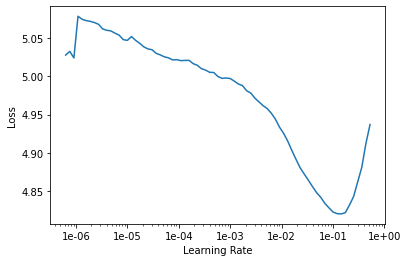

In [0]:
learn_model.recorder.plot(skip_end=15) # to plot the LR

In [0]:
lr = 1e-2
lr *= bs/48

In [0]:
learn_model.fit_one_cycle(1, 1e-2, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.846271,3.716349,0.394125,08:47


Now we unfreeze the layers, not just one as in the previous step

In [0]:
learn_model.unfreeze()

In [0]:
learn_model.fit_one_cycle(10, lr, moms=(0.8,0.7), wd=0.1)  # we can adjust the learning rate and run the model again if required

epoch,train_loss,valid_loss,accuracy,time
0,3.658939,3.610447,0.407588,10:10
1,3.900976,3.820876,0.389882,10:09
2,3.988875,3.912119,0.382812,10:09
3,3.940277,3.860862,0.386535,10:09
4,3.878322,3.803739,0.391520,10:10
5,3.776120,3.700991,0.401105,10:10
6,3.640770,3.592224,0.410946,10:09
7,3.497311,3.468571,0.423438,10:10
8,3.281701,3.382878,0.433480,10:10
9,3.075202,3.373697,0.434912,10:09


In [0]:
#learn_model.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

Now we will save just the encoder which will be later used for classification

In [0]:
learn_model.save_encoder('fwd_enc')
#learn_lm.save('fit_1')  # saving the fine tuned language model
#learn_lm.load('fit_1')

### Backward model

You can't directly train a bidirectional RNN for language modeling, but you can always enseble a forward and backward model. fastai provides a pretrained forward and backawrd model, so we can repeat the previous step to fine-tune the pretrained backward model. The command language_model_learner checks the data object you pass to automatically decide if it should use the pretrained forward or backward model.

In [0]:
learn_model = language_model_learner(data_bwd, AWD_LSTM,drop_mult=0.3)

In [0]:
learn_model.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.867663,3.715333,0.425850,08:50


In [0]:
learn_model.unfreeze()

In [0]:
learn_model.fit_one_cycle(10, lr, moms=(0.8,0.7),wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.644809,3.595366,0.439338,10:10
1,3.888639,3.809960,0.422575,10:09
2,3.973485,3.888426,0.414317,10:09
3,3.938116,3.853100,0.417584,10:10
4,3.864467,3.786871,0.424581,10:10
5,3.758890,3.693187,0.432540,10:10
6,3.649447,3.586125,0.442901,10:10
7,3.498498,3.465934,0.454821,10:09
8,3.278994,3.380776,0.464244,10:09
9,3.083931,3.371076,0.465724,10:09


In [0]:
learn_model.save_encoder('bwd_enc')

In [0]:
vocab = data_lm.vocab

In [0]:
vocab.stoi["stingray"]


23100

In [0]:
awd = learn_model.model[0]

In [0]:
enc = learn_model.model[0].encoder
enc.weight.size()

torch.Size([48368, 400])

In [0]:
vocab.stoi["trump"]

52

In [0]:
TEXT = "Trump is"
N_WORDS = 30
N_SENTENCES = 1

In [0]:
print("\n".join(learn_model.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))  #wont make sense since this is the output from the backward model

Trump is , " ? " trump President ? spot expensive most 's trump With on going 's what so . really , well ? election


In [0]:
learn_model.predict("This is a review about", n_words=20)

'This is a review about professed who woman international an , memoir the of author , tripping Sally To goes product the'

## Classifier Model

In [0]:
bs=32

In [0]:
data_clas.show_batch()

text,target
"xxbos xxmaj sunday xxmaj roundup xxmaj this week the nation came one step closer to giving itself over to the most dangerous and unstable potential leader in xxup u.s. history , as xxmaj donald xxmaj trump "" humbly "" accepted the xxmaj republican presidential nomination - so humbly , in fact , that he went on to claim that "" i alone can fix "" xxmaj america . xxmaj it",POLITICS
"xxbos xxmaj weekend xxmaj roundup xxmaj this week , while the xxup u.s. celebrates its independence , the world watches a modern xxmaj greek tragedy unfold as xxmaj greece votes on austere bailout terms imposed by the country 's creditors . xxmaj however the vote goes , one thing is clear : xxmaj the austerity that came with the two previous bailouts has utterly broken the xxmaj greek economy .",POLITICS
"xxbos xxmaj what xxmaj to xxmaj do xxmaj when xxmaj you 're a xxmaj pregnant xxmaj bridesmaid ( xxup photos ) xxmaj imagine that your closest friend or sister is engaged and wants you to be her bridesmaid . xxmaj after thanking her for the honor ( and asking who else will be a bridesmaid ) , you begin to wonder what you 're going to have to wear .",STYLE & BEAUTY
"xxbos xxmaj sunday xxmaj roundup xxmaj this week was dominated by news from xxmaj ferguson -- but much of what was really happening went untold by the media . xxmaj while xxup tv viewers were mostly presented with endless images of tear gas , violence and division , a fuller depiction would have revealed a community challenged by adversity , xxunk and institutional failure that responded with remarkable empathy ,",POLITICS
xxbos xxmaj the xxmaj impending ' xxmaj peaceful xxmaj war ' xxmaj between xxmaj china and xxmaj america xxmaj over xxmaj xxunk xxmaj unlike the xxmaj cold xxmaj war period -- in which the xxmaj soviet xxmaj union was isolated from the global economy -- commercial interests and trade secrets underpin the intrinsically entangled xxmaj sino - xxmaj american economic relations . xxmaj the xxunk - xxunk distinction between national,WORLD NEWS


In [0]:
data_clas_bwd = load_data(path, 'data_clas_export.pkl', bs=bs, backwards=True)   #loading data for the backward classifier

In [0]:
data_clas_bwd.show_batch()

text,target
". hearts and minds our in but polls the at only not - reject must we bet the 's that and xxmaj . bet his 's that xxmaj . america xxmaj shorting , essence in , is trump xxmaj . fear of nurturing cynical and manipulation the but fear to nothing have we , fdr xxup paraphrase to , but xxmaj . minds our in place that building by wins",POLITICS
". size hand to unrelated is responsibility of sense 's one apparently but , party of ahead country putting for much so xxmaj . problem no , sure , yeah xxmaj , effect in , said candidates other the of three all nominee as him support 'd they if asked when , country the to danger a and fraud a as trump xxmaj attacking after xxmaj . end the at",POLITICS
". street xxmaj wall xxmaj by paid highly , fact in , is he that disclosing without often , loves street xxmaj wall xxmaj that policies advocated long has hubbard xxmaj : huge are interest of conflicts those , least not but last and xxmaj . interest of conflicts own his and issues policy both discussing when dishonest even and , misleading , evasive been has hubbard xxmaj , experience",BUSINESS
". sponsors street xxmaj wall xxmaj her to acceptable be will that one the and wage to needs clinton xxmaj campaign the between fight the is watch to contest the , no xxmaj . rivals republican xxmaj her and clinton xxmaj between campaign likely the even or nomination the for battle the not is come to contest political interesting most the , ways many in xxmaj . specific very getting",POLITICS
". up ice n't do lighthouses the so , suppressed are spray and splashing the and , over freeze to tends michigan xxmaj lake xxmaj and , later any xxmaj . liquid still is lake the and , windy , xxunk icing for time typical the is december xxmaj late to mid , rule a as xxmaj . ice in covered completely was michigan xxmaj , joseph xxmaj st. xxmaj",ENVIRONMENT


### Fine tuning the forward classifier

The classifier needs a little less dropout, so we pass drop_mult=0.5 to multiply all the dropouts by this amount (it's easier than adjusting all the five different values manually). We don't load the pretrained model, but instead our fine-tuned encoder from the previous section.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn.load_encoder('fwd_enc')

In [0]:
data_clas.show_batch()

text,target
"xxbos xxmaj sunday xxmaj roundup xxmaj this week the nation came one step closer to giving itself over to the most dangerous and unstable potential leader in xxup u.s. history , as xxmaj donald xxmaj trump "" humbly "" accepted the xxmaj republican presidential nomination - so humbly , in fact , that he went on to claim that "" i alone can fix "" xxmaj america . xxmaj it",POLITICS
"xxbos xxmaj weekend xxmaj roundup : xxmaj greece xxmaj revolts ! xxmaj no sooner did the global elites leave their annual talking shop high in the xxmaj alps at xxmaj davos last week than the people spoke in xxmaj greece . xxmaj in a mutiny against an untenable status quo , those who are run over have revolted against those who run things . xxmaj now righteous populism must face",WORLD NEWS
"xxbos xxmaj weekend xxmaj roundup : a xxmaj pattern of xxmaj crises xxmaj connects xxmaj cologne and xxmaj istanbul xxmaj even before the "" xxmaj night of xxmaj shame "" on xxmaj new xxmaj year 's xxmaj eve in xxmaj cologne further fueled an already fervent anti - foreigner backlash , xxmaj german leaders were desperately looking to xxmaj turkey to stem the flow of refugees headed to xxmaj europe",WORLD NEWS
xxbos xxmaj sunday xxmaj roundup xxmaj happy 4th of xxmaj july weekend ! xxmaj the week leading up to the holiday gave us much to celebrate -- and much not to celebrate . xxmaj we can certainly rejoice that xxmaj hurricane xxmaj arthur failed to do much damage before weakening and heading out to sea . xxmaj but there can only be consternation at the xxmaj supreme xxmaj court 's,POLITICS
"xxbos xxmaj as a xxmaj millennial : xxmaj these are ( some of ) my issues for the xxmaj upcoming xxmaj election xxmaj part xxup ii xxmaj even more important , is for presidential candidates to take the campaigning process seriously . xxmaj as xxmaj florida xxmaj senator xxmaj marco xxmaj rubio pointed out earlier this week , "" this is n't joke , this is serious "" , and",POLITICS


In [0]:
lr = 1e-2
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.251260,1.114925,0.675978,02:29


In [0]:
learn.freeze_to(-2)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.127856,1.016343,0.704696,02:45


In [0]:
learn.save('last2')

In [0]:
learn.load('last2')

In [0]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.059443,0.947615,0.720154,04:30


In [0]:
learn.save('last3')

In [0]:
learn.load('last3')

In [0]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(10, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.975720,0.936779,0.723606,06:09
1,0.952977,0.929297,0.726784,06:27
2,0.936199,0.916819,0.730668,06:28
3,0.909337,0.906673,0.732983,05:57
4,0.852579,0.905054,0.734552,06:05
5,0.841902,0.902857,0.736788,06:30
6,0.793678,0.902617,0.735965,06:25
7,0.732816,0.900760,0.738240,05:53
8,0.687144,0.904889,0.738397,06:30
9,0.724657,0.901386,0.738358,05:47


In [0]:
learn.save('fwd_clas')

In [0]:
preds,targs = learn.get_preds(ordered=True)

In [0]:
accuracy(preds,targs)

tensor(0.7384)

In [0]:
learn.load('fwd_clas')

### Backward Classifier

Then we do the same thing for the backward model, the only thigns to adjust are the names of the data object and the fine-tuned encoder we load.

In [0]:
learn_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_bwd.load_encoder('bwd_enc')

In [0]:
lr = 1e-2
learn_bwd.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.610163,1.376194,0.610577,02:49


In [0]:
learn_bwd.freeze_to(-2)
lr /= 2
learn_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.249493,1.073496,0.691789,03:20


In [0]:
learn_bwd.save('twolayers_bwd')

In [0]:
learn_bwd.load('twolayers_bwd')

In [0]:
learn_bwd.freeze_to(-3)
lr /= 2
learn_bwd.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.058453,0.972882,0.717054,05:32


In [0]:
learn_bwd.save('threelayer_bwd')

In [0]:
learn_bwd.load('threelayer_bwd')

In [0]:
learn_bwd.unfreeze()
lr /= 5
learn_bwd.fit_one_cycle(10, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.980517,0.961231,0.720664,07:06
1,0.996031,0.946244,0.724783,07:39
2,0.958775,0.931075,0.727765,07:23
3,0.920023,0.927698,0.731139,07:14
4,0.896530,0.914094,0.734317,07:23
5,0.875249,0.909889,0.738397,07:19
6,0.767028,0.904272,0.742046,07:00
7,0.760504,0.913675,0.742438,07:22
8,0.737534,0.905788,0.743183,07:16
9,0.710762,0.905992,0.743536,07:42


In [0]:
preds_bwd,targs_bwd = learn_bwd.get_preds(ordered=True)
accuracy(preds_bwd,targs_bwd)

tensor(0.7435)

In [0]:
learn_bwd.save('bwd_clas')

## Ensembling the two models


For our final results, we'll take the average of the predictions of the forward and the backward models. SInce the samples are sorted by text lengths for batching, we pass the argument ordered=True to get the predictions in the order of the texts.

In [0]:
pred_fwd,lbl_fwd = learn.get_preds(ordered=True)

In [0]:
pred_bwd,lbl_bwd = learn_bwd.get_preds(ordered=True)

In [0]:
final_pred = (pred_fwd+pred_bwd)/2

In [0]:
accuracy(final_pred, lbl_fwd)
#tensor(0.7516)

tensor(0.7516)

#Transfer Learning using BERT


BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others

In [0]:
!pip install pytorch-pretrained-bert

In [0]:
from pytorch_pretrained_bert import BertTokenizer

In [10]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # smaller version, no capitalized words

100%|██████████| 231508/231508 [00:00<00:00, 922562.85B/s]


In [0]:
with open("vocabulary.txt", 'w') as f:
    
    # For each token...
    for token in tokenizer.vocab.keys():
        
        # Write it out and escape any unicode characters.            
        f.write(token + '\n')

Maximum token length: 18


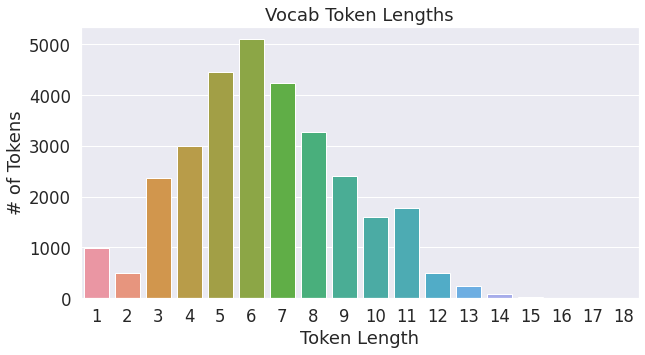

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Measure the length of every token in the vocab.
token_lengths = [len(token) for token in tokenizer.vocab.keys()]

# Plot the number of tokens of each length.
sns.countplot(token_lengths)
plt.title('Vocab Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('# of Tokens')

print('Maximum token length:', max(token_lengths));

In [0]:
#find number of subwords where the subword begins with 2 #'s
num_subwords = 0

subword_lengths = []

# For each token in the vocabulary...
for token in tokenizer.vocab.keys():
    
    # If it's a subword...
    if len(token) >= 2 and token[0:2] == '##':
        
        # Tally all subwords
        num_subwords += 1

        # Measure the sub word length (without the hashes)
        length = len(token) - 2

        # Record the lengths.        
        subword_lengths.append(length)

In [0]:
vocab_size = len(tokenizer.vocab.keys())

print('Number of subwords: {:,} of {:,}'.format(num_subwords, vocab_size))

# Calculate the percentage of words that are '##' subwords.
prcnt = float(num_subwords) / vocab_size * 100.0

print('%.1f%%' % prcnt)

Number of subwords: 5,828 of 30,522
19.1%


Text(0, 0.5, '# of ## Subwords')

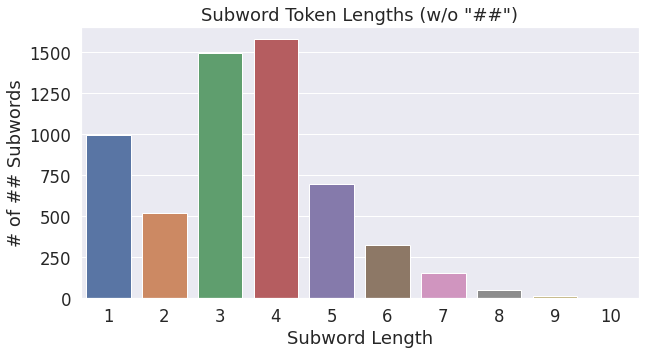

In [0]:
#plot of subwords where the ##'s are removed (from the 5,828) - so most subwords have 4 letters after the two #s
sns.countplot(subword_lengths)
plt.title('Subword Token Lengths (w/o "##")')
plt.xlabel('Subword Length')
plt.ylabel('# of ## Subwords')

Check for GPU

In [11]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [12]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Installing the Hugging Face library - for Transformers

In [0]:
!pip install transformers

We will use BertForSequenceClassification.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.

## Bert Tokenizer

In [14]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
train_df.loc[0][1]

"Luke From 'Gilmore Girls' Is Getting His Own Line Of Coffee We have a feeling Lorelai would've loved this."

In [0]:
# Print the original sentence.
print(' Original: ', train_df.loc[0][1])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_df.loc[0][1]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_df.loc[0][1])))

 Original:  Luke From 'Gilmore Girls' Is Getting His Own Line Of Coffee We have a feeling Lorelai would've loved this.
Tokenized:  ['luke', 'from', "'", 'gilmore', 'girls', "'", 'is', 'getting', 'his', 'own', 'line', 'of', 'coffee', 'we', 'have', 'a', 'feeling', 'lore', '##lai', 'would', "'", 've', 'loved', 'this', '.']
Token IDs:  [5355, 2013, 1005, 22999, 3057, 1005, 2003, 2893, 2010, 2219, 2240, 1997, 4157, 2057, 2031, 1037, 3110, 19544, 19771, 2052, 1005, 2310, 3866, 2023, 1012]


In [0]:
train_df[['text']],len(train_df),len(valid_df)

(                                                     text
 0       Luke From 'Gilmore Girls' Is Getting His Own L...
 1       The Huffington Post Is Hiring A Tech Reporter ...
 2       Simple Greek: Baked Sardines From Diane Kochil...
 3       Political Workout Music For The Convention Glu...
 4       AP Uses Jordan Peele Photo While Tweeting Abou...
 ...                                                   ...
 144433  Why I Choose To Embrace Failures Leadership Gu...
 144434  Wedding Etiquette Mistakes You Didn't Know You...
 144435  Screen-Free Week: Go Outside and Learn to Ride...
 144436   Is Weight Gain A Deterrent To Quitting Smoking? 
 144437  PSL Season Has Officially Returned To Starbuck...
 
 [144438 rows x 1 columns], 144438, 25489)

### Preprocessing input data to be fed into BERT

In [0]:
data=pd.concat([train_df, valid_df], ignore_index=True)

In [0]:
df = data.copy()

In [0]:
df.category = pd.Categorical(df.category)
df['code'] = df.category.cat.codes

Find max sentence length

In [0]:
max_len = 0

# For every sentence...
for sent in data.text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len) 

Max sentence length:  318


*The label column should be numeric for it to be passed to the torch.tensor function*

*The special tokens, padding and attention masks and created in this step using .encode_plus from hugging face library*

In [19]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in df.text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 324,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.LongTensor(df.code)

# Print sentence 0, now as a list of IDs.
print('Original: ', df.text[0])
print('Token IDs:', input_ids[0])

Original:  Luke From 'Gilmore Girls' Is Getting His Own Line Of Coffee We have a feeling Lorelai would've loved this.
Token IDs: tensor([  101,  5355,  2013,  1005, 22999,  3057,  1005,  2003,  2893,  2010,
         2219,  2240,  1997,  4157,  2057,  2031,  1037,  3110, 19544, 19771,
         2052,  1005,  2310,  3866,  2023,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0

In [0]:
tokenizer.vocab.items()
vocab = list(tokenizer.vocab.keys())

In [0]:
vocab[5355],vocab[2013]

('luke', 'from')

### Training and Validation set

In [20]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 70-30 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

118,948 training samples
50,979 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [0]:
#For fine-tuning BERT on a specific task, the authors recommend a batch  size of 16 or 32.
batch_size = 16  #This is required for the DataLoader

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## BertForSequenceClassification. 
This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 31, # The number of output labels
                       
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

The dimensions and weights of each layer in the model is given below

- The embedding layer.

- The first of the twelve transformers.

- The output layer.

In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## Optimizer and Learning Rate scheduler

*For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper):*

- Batch size: 16, 32

- Learning rate (Adam): 5e-5, 3e-5, 2e-5

- Number of epochs: 2, 3, 4


*Chosen values*

- Batch size: 32 (set when creating our DataLoaders)

- Learning rate: 2e-5

- Epochs: 4 

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
#'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# epochs to be between 2 and 4  
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training

Accuracy helper function

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

To print out the time elapsed

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
import random
import numpy as np

# Set the seed value to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
########################## Training ##################################
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. The call to `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training vs. test 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. As we unpack the batch, we'll also copy each tensor to the GPU using the  `to` method.

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        bat_input_ids = batch[0].to(device)
        bat_input_mask = batch[1].to(device)
        bat_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because accumulating the gradients is "convenient while training RNNs". 
        # helps free up space as well
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # It returns different numbers of parameters depending on what arguments are given and what flags are set. Here, it returns
        # the loss (because we provided labels) and the "logits"--the model outputs prior to activation.
        loss, logits = model(bat_input_ids, 
                             token_type_ids=None, 
                             attention_mask=bat_input_mask, 
                             labels=bat_labels)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()  #backpropogation

        # Clip the norm of the gradients to 1.0 to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient. The optimizer does this step and unless its called the weight updation wont happen
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        

########################## VALIDATION ################################

    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 

        # As we unpack the batch, we'll also copy each tensor to the GPU using  the `to` method as done in the training module

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training). Helps in saving memory
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
           
            # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Summary

In [30]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.52,1.00,0.75,1:05:22,0:08:59
2,0.48,0.96,0.75,1:05:18,0:08:59
3,0.32,1.03,0.75,1:05:15,0:08:59
4,0.26,1.03,0.75,1:05:18,0:09:00


Plotting the Training and Validation loss

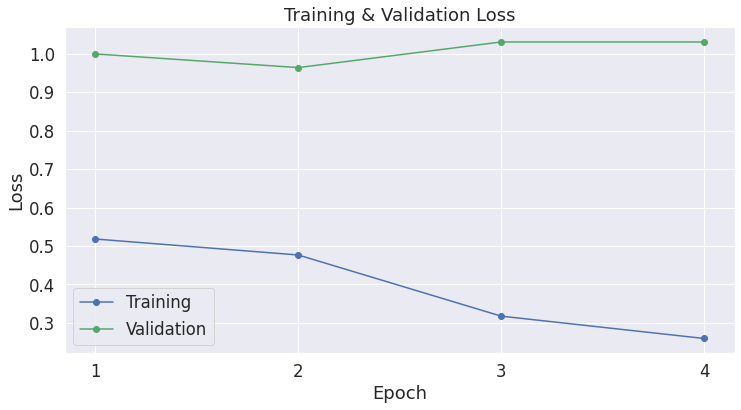

In [32]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show();

## Save model

In [34]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './saving_BERT/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./saving_BERT/


('./saving_BERT/vocab.txt',
 './saving_BERT/special_tokens_map.json',
 './saving_BERT/added_tokens.json')

In [0]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./saving_BERT/ "./drive/My Drive/Data/BERT/"

In [0]:
# Load a trained model and vocabulary that you have fine-tuned
model = model.from_pretrained(output_dir)
tokenizer = tokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)